In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

from matplotlib import patches
from PIL import Image

from collections import Counter

import torch
from torch import nn
from torch import optim
from torch.nn import Module
from torch.nn import functional as f
from torch.nn.modules.activation import Sigmoid
from torch.nn.modules.conv import Conv2d
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision import utils as Vision_utils
from torchvision import models
from torchvision import transforms
from torchvision.transforms import functional as TF

from glob import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Dataloader

In [2]:
class VOCDataset(Dataset):
    def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transforms = None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.S = S
        self.B = B
        self.C = C
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = list()
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, w, h = [
                    float(x) if float(x) != int (float(x)) 
                            else int(x) for x in label.replace("\n", "").split()
                ]
                boxes.append([class_label, x, y, w, h])
        
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transforms is not None:
            image, boxes = self.transforms(image, boxes)
        
        label_matrix = torch.zeros((self.S, self.S, self.B*5 + self.C))
        for box in boxes:
            class_label, x, y, w, h = box.tolist()
            class_label = int(class_label)

            #i, j biểu diễn cho chỉ số hàng và cột của ô lưới chứa boundbox 
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S *y - i
            w_cell, h_cell = (w * self.S, h * self.S)

            if label_matrix[i, j, 20] == 0:
                label_matrix[i, j, 20] = 1

                box_coordinates = torch.tensor(
                    [x_cell, y_cell, w_cell, h_cell]
                )
                label_matrix[i, j, 21:25] = box_coordinates
                label_matrix[i, j, class_label] = 1
        
        return image, label_matrix


In [3]:
def intersection_over_union(boxes_preds, boxes_labels, box_format= "midpoint"):
    """
    Tính toán mức độ chồng lấn giữa các boxes giới hạn
    Parameters: 
        boxes_preds (tensor): Dự đoán về các box giới hạn (BATCH_SIZE, 4)
        boxes_labels (tensor): Nhãn chính xác của các box giới hạn (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, nếu box giới hạn được biểu diễn dưới dạng (x,y,w,h) hoặc (x1,y1,x2,y2)
    Returns:
        tensor: Độ chồng lấn giữa các ví dụ
    """
    # Kiểm tra định dạng: "midpoint"
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    
    if box_format == "corners":
        # Trích xuất tọa độ cho các box dự đoán
        box1_x1 = boxes_preds[:, 0:1]
        box1_y1 = boxes_preds[:, 1:2]
        box1_x2 = boxes_preds[:, 2:3]
        box1_y2 = boxes_preds[:, 3:4]

        # Trích xuất tọa độ cho nhãn thực
        box2_x1 = boxes_labels[:, 0:1]
        box2_y1 = boxes_labels[:, 1:2]
        box2_x2 = boxes_labels[:, 2:3]
        box2_y2 = boxes_labels[:, 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2) 
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    
    box1_area = abs((box1_x2-box1_x1) * (box1_y2-box1_y1))
    box2_area = abs((box2_x2-box2_x1) * (box2_y2-box2_y1))

    return intersection/(box1_area + box2_area - intersection + 1e-6)


In [ ]:
def non_maximum_suppression(bboxes, iou_threshold, threshold, box_format= "corners"):
    """
    Thực hiện Non-Maximum Suppression trên danh sách các box giới hạn
    Parameters:
        bboxes (list): Danh sách các box giới hạn, mỗi box được biểu diễn như [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): Ngưỡng IoU để xác định box giới hạn dự đoán là đúng
        threshold (float): Ngưỡng để loại bỏ các box giới hạn dự đoán (không phụ thuộc vào IoU)
        box_format (str): "midpoint" hoặc "corners" để chỉ định định dạng của box giới hạn
    Returns:
        list: Danh sách các box giới hạn sau khi thực hiện NMS với một ngưỡng IoU cụ thể
    """
    assert type(bboxes) == list
    
    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key= lambda x: x[1], reverse= True)

    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)
        bboxes = [
            box for box in bboxes
            if box[0] != chosen_box[0] or 
            intersection_over_union(
                torch.tensor(chosen_box[2:], 
                torch.tensor(box[2:])),
                box_format= box_format
                ) < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)
    
    return bboxes_after_nms

In [5]:
def mean_average_precison(
        pred_boxes, true_boxes, iou_threshold= 0.6, 
        box_format= 'midpoint', num_classes= 20
    ):
    """
    Tính giá trị trung bình mAP
    Parameters:
        + pred_boxes (list): Danh sách chứa các boxes giới hạn dự đoán với mỗi box được chỉ...
        ...định như [train_idx, class_prediction, prob_score, x1, y1, x2, y2].
        + true_boxes (list): Tương tự với pred_boxes với định dạng tương tự.
        + iou_threshold: ngưỡng IoU, nơi các box dự đoán được xem là đúng.
        + box_format (str): 'midpoint' & 'corner' được sử dụng để chỉ định định dạng box.
        + num_classes: Số lượng lớp.
    Return: 
        float: Giá trị mAP qua tất cả các lớp với một ngưỡng IoU cụ thể
    """
    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []
        # Lọc qua các dự đoán đối với phân lớp hiện tại
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)
        
        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)
        
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.tensor(val) # Số lượng boxes cho mỗi class huấn luyện
        
        detections.sort(key= lambda x: x[2], reverse= True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_boxes = len(ground_truths)

        if total_true_boxes==0: continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format= box_format
                )
                if iou > best_iou:
                    best_iou = iou
                    best_iou_idx = idx
            
            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_iou_idx] == 0: 
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_iou_idx] = 1
                else: FP[detection_idx] = 1
            
            else: FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim= 0)
        FP_cumsum = torch.cumsum(FP, dim= 0)
        recalls = TP_cumsum/(total_true_boxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz để tích hợp số
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [6]:
def plot_image(image, boxes):
    im = np.array(image)
    height, width, _ = im.shape

    fig, ax = plt.subplots(1)
    ax.imshow(im)

    for box in boxes:
        # |box[2:]| = [x_ctr, y_ctr, width, height]
        box = box[2:]
        assert len(box) == 4, "Có nhiều hơn x, y, w, h trong 1 box"
        upper_left_x = box[0] - box[2]/2
        upper_left_y = box[1] - box[3]/2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height), 
            width= box[2]*width, height= box[3]*height, 
            linewidth = 1,
            edgecolor= 'r', facecolor= 'none'
        )
        ax.add_patch(rect)

    plt.show()

In [7]:
def convert_cellboxes(predictions, S=7):
    """
    Chuyển đổi các hộp giới hạn được đầu ra từ YOLO với kích thước chia ảnh S...
    ...thành tỷ lệ của toàn bộ ảnh thay vì tỷ lệ của ô.
    """
    
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(-1)
    
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

In [8]:
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

# Lưu trạng thái của mô hình và bộ tối ưu vào một tệp checkpoint. 
# Mặc định là "checkpoint_model.tar".
def save_checkpoint(state, filename="checkpoint_model.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

# Tải trạng thái của mô hình và bộ tối ưu từ một checkpoint đã được lưu trước đó.
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [9]:
def get_bboxes(loader, model, iou_threshold, 
               threshold, pred_format= 'cells', 
               box_format= 'midpoint', device='cuda'):
    all_pred_boxes = []
    all_true_boxes = []

    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)
        
        batch_size = x.size(0)
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_maximum_suppression(
                bboxes[idx],
                iou_threshold = iou_threshold,
                threshold = threshold,
                box_format = box_format,
            )

            if batch_idx == 0 and idx == 0:
                plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
                print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1
    model.train()
    return all_pred_boxes, all_true_boxes

# Model Architecture

In [10]:
# Mô tả các lớp convolution và max pooling, số lần lặp lại các khối convolution.
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [11]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias= False, **kwargs)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        return self.relu(self.batch_norm(self.conv(x)))

In [12]:
class YOLOv1(nn.Module):
    def __init__(self, in_channels= 3, **kwargs):
        super(YOLOv1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.dark_net = self._create_conv_layer(self.architecture)
        self.fcs = self._create_fcs(**kwargs)
    
    def forward(self, x):
        x = self.dark_net(x)
        return self.fcs(torch.flatten(x, start_dim= 1))
    
    def _create_conv_layer(self, architecture):
        layers = []
        in_channels = self.in_channels
        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(in_channels, x[1], kernel_size= x[0], stride= x[2], padding= x[3])
                ]
                in_channels = x[1]
            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size= (2,2), stride= (2,2))]
            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                repeats = x[2]

                for _ in range(repeats):
                    layers += [
                        CNNBlock(in_channels, conv1[1], 
                                 kernel_size= conv1[0], 
                                 stride= conv1[2], 
                                 padding= conv1[3])
                    ]
                    layers += [
                        CNNBlock(conv1[1], 
                                 conv2[1], 
                                 kernel_size= conv2[0], 
                                 stride= conv2[2], 
                                 padding= conv2[3])
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)
    def _create_fcs(self, S, B, C):
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496), 
            nn.Dropout(0.1), 
            nn.LeakyReLU(),
            nn.Linear(496, S*S*(B*5+C))
        )

# YOLO Loss

In [13]:
class YOLO_Loss(nn.Module):
    def __init__(self, S=7, B= 2, C= 20):
        super(YOLO_Loss, self).__init__()
        self.mse = nn.MSELoss(reduction='sum')

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.B*5 + self.C) 
        
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], axis= 0)

        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)

        box_predictions = exists_box * (
            bestbox * predictions[..., 26:30]
            + (1 - bestbox) * predictions[..., 21:25]
        )
        box_targets = exists_box * target[..., 21:25]
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )
        
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss + object_loss + self.lambda_noobj * no_object_loss + class_loss
        )

        return loss

# Training Loop

In [14]:
seed = 123
torch.manual_seed(seed)

# Hyperparameters
LEARNING_RATE = 2e-5
DEVICE = torch.device("cuda")
# 64 trong bài báo gốc, sử dụng kích thước lô nhỏ hơn do hạn chế về GPU
BATCH_SIZE = 32
WEIGHT_DECAY = 0
EPOCHS = 100
# Số lượng quy trình WORKER để tải dữ liệu.
NUM_WORKERS = 0

# Nếu Đúng, DataLoader sẽ ghim bộ nhớ để truyền dữ liệu tới GPU nhanh hơn.
PIN_MEMORY = True
# Nếu Sai, quá trình đào tạo sẽ tải mô hình được huấn luyện trước.
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"

# Thư mục chứa hình ảnh.
IMG_DIR = r'D:\Studying\Personal_Project\Computer Vision\PascalVOC YOLO\data\pascalvoc-yolo\images'
# Thư mục chứa các nhãn tương ứng.
LABEL_DIR = r'D:\Studying\Personal_Project\Computer Vision\PascalVOC YOLO\data\pascalvoc-yolo\labels'

In [15]:
class Composer(object):
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, img, boxes):
        for t in self.transforms:
            img, boxes = t(img), boxes
        return img, boxes

transformer = Composer([transforms.Resize((448, 448)), transforms.ToTensor()])

def train(train_loader, model, criterion, optimizer):
    loop = tqdm(train_loader, leave= True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = criterion(out, y)
        mean_loss.append(loss)
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss= loss.item())

    print(f"Mean loss: {sum(mean_loss)/len(mean_loss)}")

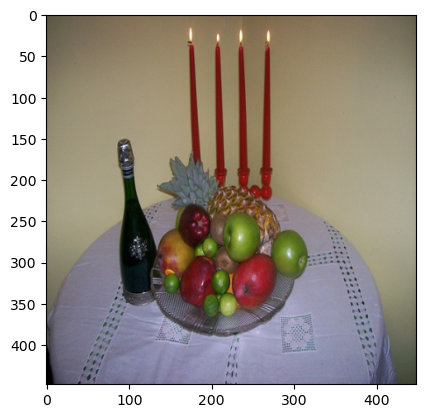

[]
Train mAP: 0.0


  0%|          | 0/3 [00:00<?, ?it/s]d:\anaconda3\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 3/3 [01:03<00:00, 21.32s/it, loss=2.01e+3]


Mean loss: 2149.830810546875


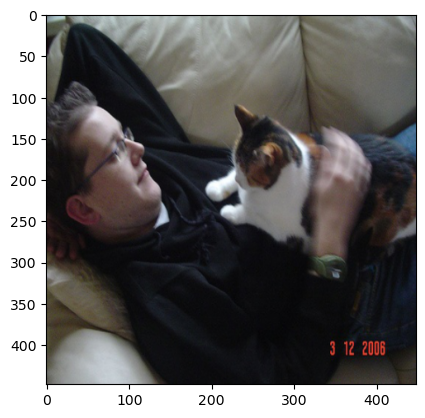

[]
Train mAP: 0.0


 67%|██████▋   | 2/3 [00:43<00:21, 21.73s/it, loss=1.56e+3]


KeyboardInterrupt: 

In [16]:
def main():
    model = YOLOv1(in_channels= 3, S= 7, B= 2, C= 20).to(DEVICE)
    criterion = YOLO_Loss()
    optimizer = optim.Adam(
        model.parameters(), lr= LEARNING_RATE, weight_decay= WEIGHT_DECAY
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)
    
    train_dataset = VOCDataset(
        csv_file= r"D:\Studying\Personal_Project\Computer Vision\PascalVOC YOLO\data\pascalvoc-yolo\100examples.csv",
        img_dir= IMG_DIR,
        label_dir= LABEL_DIR,
        transforms= transformer
        )
    test_dataset = VOCDataset(
        csv_file= r"D:\Studying\Personal_Project\Computer Vision\PascalVOC YOLO\data\pascalvoc-yolo\8examples.csv",
        img_dir= IMG_DIR,
        label_dir= LABEL_DIR,
        transforms= transformer
    )

    train_loader = DataLoader(
        train_dataset, batch_size= BATCH_SIZE,
        shuffle= True, num_workers= NUM_WORKERS,
        pin_memory= PIN_MEMORY, drop_last= True
        )
    
    test_loader = DataLoader(
        test_dataset, batch_size= BATCH_SIZE,
        shuffle= False, num_workers= NUM_WORKERS,
        pin_memory= PIN_MEMORY, drop_last= True
        )
    
    for epoch in range(EPOCHS):
        pred_boxes, target_boxes = get_bboxes(
            train_loader, model,
            iou_threshold= 0.5, threshold= 0.4
        )
        mAP = mean_average_precison(
            pred_boxes, target_boxes, 
            iou_threshold=0.5, box_format= 'midpoint'
        )
        print(f'Train mAP: {mAP}')

        if mAP > 0.9: 
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict()
            }
            save_checkpoint(checkpoint, filename= LOAD_MODEL_FILE)
            
        train(train_loader, model, criterion, optimizer)

main()